In [2]:
import os
import numpy as np
import pandas as pd
import h5py
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import nbformat
import plotly.express as px
from IPython.display import HTML
import re
import MDAnalysis as md
from MDAnalysis.tests.datafiles import PSF, DCD, DCD2
from MDAnalysis.analysis.base import (AnalysisBase, AnalysisFromFunction, analysis_class)
import umap as UMAP


/home/mans/.conda/envs/mdsenv/lib/python3.8/site-packages/MDAnalysisTests/datafiles.py:229: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


In [3]:
def bin_plane(xyz, plane_size, L, num_bins, detector_eff=1.0, axis=1):
    if detector_eff > 1.0:
        raise ValueError("Detector efficiency cannot be over 100%.")

    
    # Create the grid
    grid_range = np.linspace(-plane_size / 2, plane_size / 2, num_bins)
    
    if axis == 0:
        grid = np.array([(-L, x, y) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 1
        B2 = 2
    elif axis == 1:
        grid = np.array([(x, -L, y) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 0
        B2 = 2
    elif axis == 2:
        grid = np.array([(x, y, -L) for y in grid_range for x in grid_range], dtype=np.float32)
        B1 = 1
        B2 = 0
    else:
        raise ValueError("Invalid axis value. Axis must be 0, 1, or 2.")
    
    # Filter out points that will never hit the plane based on their y-coordinate and the plane's location
    if L > 0:
        xyz = xyz[xyz[:, axis] < 0.0]  # Points above the plane when L > 0 will not hit
    elif L < 0:
        xyz = xyz[xyz[:, axis] > 0.0]  # Points below the plane when L < 0 will not hit

    # Calculate the hit locations on the plane
    k = -L / xyz[:, axis]
    hit_location = k[:, np.newaxis] * xyz

    # Initialize the bins
    bins = np.zeros((num_bins, num_bins), dtype=int)

    N = len(hit_location)
    M = int(detector_eff * N)
    
    keep_idx = np.random.choice(N, M, replace=False)
    hit_location = hit_location[keep_idx]

    # Process each hit location
    for hit in hit_location:
        # Check if the hit is within the plane bounds
        if -plane_size / 2 <= hit[B1] <= plane_size / 2 and -plane_size / 2 <= hit[B2] <= plane_size / 2:
            # Find the closest grid point for the hit location
            distance = scipy.spatial.distance.cdist([hit], grid)
            closest_bin = np.argmin(distance)

            # Convert the linear index to 2D index and increment the corresponding bin
            y_idx, x_idx = divmod(closest_bin, num_bins)
            bins[y_idx, x_idx] += 1

    return bins.astype(np.int16)

In [4]:
def PCA_analysis(img_data, n_components=2):
    # Convert the list of lists into a numpy array of shape (len(img_data), bins, bins)
    data_array = np.array(img_data) 
    
    # Reshape it into (len(img_data), bins*bins) so each row represents one sample
    data_matrix = data_array.reshape(len(img_data), -1) 
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    transformed_data = pca.fit_transform(data_matrix)
    return transformed_data

def TSNE_analysis(img_data, n_components=2, perplexity=50.0, random_state=None):
    # Convert the list of lists into a numpy array of shape (len(img_data), bins, bins)
    data_array = np.array(img_data)  
    
    # Reshape it into (len(img_data), bins*bins) so each row represents one sample
    data_matrix = data_array.reshape(len(img_data), -1)  
    
    # Apply TSNE
    tsne = TSNE(n_components=n_components, verbose=0, perplexity=perplexity, random_state=random_state)
    transformed_data = tsne.fit_transform(data_matrix)
    return transformed_data

def UMAP_analysis(img_data, n_components=2, n_neighbors=15, metric='euclidean', random_state=None):
    # Convert the list of lists into a numpy array of shape (len(img_data), bins, bins)
    data_array = np.array(img_data)  
    
    # Reshape it into (len(img_data), bins*bins) so each row represents one sample
    data_matrix = data_array.reshape(len(img_data), -1) 
    
    # Apply UMAP
    umap = UMAP.UMAP(n_components=n_components, n_neighbors=n_neighbors, metric=metric, random_state=random_state)
    transformed_data = umap.fit_transform(data_matrix)
    return transformed_data

#For sorting the lists
def extract_number(s):
    return int(''.join(filter(str.isdigit, s)))


Radius of Gyration

In [41]:
what_run1 = 'run0'
what_run2 = 'run8'
efield ='3e4'

def radgyr(atomgroup, masses, total_mass=None):
    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()

    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y

    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])

    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

#Get RoG
cwd_long1 = f'/home/mans/E_3e4/{what_run1}'
cwd_long2 = f'/home/mans/E_3e4/{what_run2}' 

u1 = md.Universe(f'{cwd_long1}/long.gro', f'{cwd_long1}/long.trr')
u2 = md.Universe(f'{cwd_long2}/long.gro', f'{cwd_long2}/long.trr')

protein1 = u1.select_atoms('protein')
protein2 = u2.select_atoms('protein')
idx1 = protein1.indices
idx2 = protein2.indices

rog1 = md.analysis.base.AnalysisFromFunction(radgyr, u1.trajectory,
                        protein1, protein1.masses,
                        total_mass=np.sum(protein1.masses))
rog2 = md.analysis.base.AnalysisFromFunction(radgyr, u2.trajectory,
                        protein2, protein2.masses,
                        total_mass=np.sum(protein2.masses))
rog1.run(start=0, stop=1001, step=10)
rog2.run(start=0, stop=1001, step=10)

rog1.results['timeseries'].shape
rog2.results['timeseries'].shape

rog1_list = []
rog2_list = []
labels = ['all', 'x-axis', 'y-axis', 'z-axis']

#RoG1
for col, label in zip(rog1.results['timeseries'].T, labels):
    if label == 'all':
        rog1_list.append(col)

one_run_rog1 = np.concatenate(rog1_list).tolist()
print(len(one_run_rog1))

flattened_rog1 = []
for i in one_run_rog1:
    for j in range(100):
        flattened_rog1.append(i)

print('rog 1: ', len(flattened_rog1))

#RoG2
for col, label in zip(rog2.results['timeseries'].T, labels):
    if label == 'all':
        rog2_list.append(col)

one_run_rog2 = np.concatenate(rog2_list).tolist()
print(len(one_run_rog2))

flattened_rog2 = []
for i in one_run_rog2:
    for j in range(100):
        flattened_rog2.append(i)

print('rog 2: ', len(flattened_rog2))

101
rog 1:  10100
101
rog 2:  10100


/home/mans/.conda/envs/mdsenv/lib/python3.8/site-packages/MDAnalysis/lib/mdamath.py:300: RuntimeWarning:

invalid value encountered in scalar divide

/home/mans/.conda/envs/mdsenv/lib/python3.8/site-packages/MDAnalysis/lib/mdamath.py:301: RuntimeWarning:

invalid value encountered in scalar divide

/home/mans/.conda/envs/mdsenv/lib/python3.8/site-packages/MDAnalysis/lib/mdamath.py:302: RuntimeWarning:

invalid value encountered in scalar divide



For 100 simulations

In [7]:

cwd1 = f'/home/mans/moldstruct_python/3e4_{what_run1}_100sims_mds'
cwd2 = f'/home/mans/moldstruct_python/3e4_{what_run2}_100sims_mds'

fold_dirs = os.listdir(f'{cwd1}')
fold_dirs.sort()
print(fold_dirs)

allsim_posdata1 = []
allsim_posdata2 = []

for fold in fold_dirs:
    for i in range(100):
        h5file1 = f'{cwd1}/{fold}/sim{i}/data.h5'
        h5file2 = f'{cwd2}/{fold}/sim{i}/data.h5'
        # Exctract the position data (unit displacement)
        with h5py.File(h5file1, 'r') as file:   #how to open h5 file: h5dump name
            group_path ='ALL_FOLDS_1UBI'
            group = file[group_path]
            pos_data1 = group["unit_displacement"][:]
        pos_data1 = np.array(pos_data1)
        allsim_posdata1.append(pos_data1)
        with h5py.File(h5file2, 'r') as file:   #how to open h5 file: h5dump name
            group_path ='run8_ALL_FOLDS_1UBI'
            group = file[group_path]
            pos_data2 = group["unit_displacement"][:]
        pos_data2 = np.array(pos_data2)
        allsim_posdata2.append(pos_data2)


print(what_run1, len(allsim_posdata1))
print(what_run2, len(allsim_posdata2))


['1ubi_000', '1ubi_001', '1ubi_002', '1ubi_003', '1ubi_004', '1ubi_005', '1ubi_006', '1ubi_007', '1ubi_008', '1ubi_009', '1ubi_010', '1ubi_011', '1ubi_012', '1ubi_013', '1ubi_014', '1ubi_015', '1ubi_016', '1ubi_017', '1ubi_018', '1ubi_019', '1ubi_020', '1ubi_021', '1ubi_022', '1ubi_023', '1ubi_024', '1ubi_025', '1ubi_026', '1ubi_027', '1ubi_028', '1ubi_029', '1ubi_030', '1ubi_031', '1ubi_032', '1ubi_033', '1ubi_034', '1ubi_035', '1ubi_036', '1ubi_037', '1ubi_038', '1ubi_039', '1ubi_040', '1ubi_041', '1ubi_042', '1ubi_043', '1ubi_044', '1ubi_045', '1ubi_046', '1ubi_047', '1ubi_048', '1ubi_049', '1ubi_050', '1ubi_051', '1ubi_052', '1ubi_053', '1ubi_054', '1ubi_055', '1ubi_056', '1ubi_057', '1ubi_058', '1ubi_059', '1ubi_060', '1ubi_061', '1ubi_062', '1ubi_063', '1ubi_064', '1ubi_065', '1ubi_066', '1ubi_067', '1ubi_068', '1ubi_069', '1ubi_070', '1ubi_071', '1ubi_072', '1ubi_073', '1ubi_074', '1ubi_075', '1ubi_076', '1ubi_077', '1ubi_078', '1ubi_079', '1ubi_080', '1ubi_081', '1ubi_082', '1u

Inputs

In [34]:
plane_size = 200 #Plane size (regular is 200)
detector_distance = 50 #Detector distance (regular in 50)
num_bins = 30 #Number of bins (meaning how many bins that should fit the plane, regular is 60)
#rot_axis = input('What axis do you want to rotate around?: ')

detector_eff = 1.0 # effciency of detector
axis = 2 #Where to place the detector relative to the reference frame of the data
# 0 -> x
# 1 -> y
# 2 -> z
if axis == 0:
    axis_xyz = 'x'
elif axis == 1:
    axis_xyz = 'y'
else:
    axis_xyz = 'z'

#For image
all_img1= []

for pos_data in allsim_posdata1:
    img = np.ndarray(shape=(num_bins,num_bins))
    img = bin_plane(pos_data,plane_size,detector_distance,num_bins,detector_eff,axis)
    all_img1.append(img)

all_img2= []

for pos_data in allsim_posdata2:
    img = np.ndarray(shape=(num_bins,num_bins))
    img = bin_plane(pos_data,plane_size,detector_distance,num_bins,detector_eff,axis)
    all_img2.append(img)


Stack the runs

In [35]:
all_img_stack= np.vstack((all_img1, all_img2))
all_img_stack.shape

(20200, 30, 30)

Classification

101
101
202


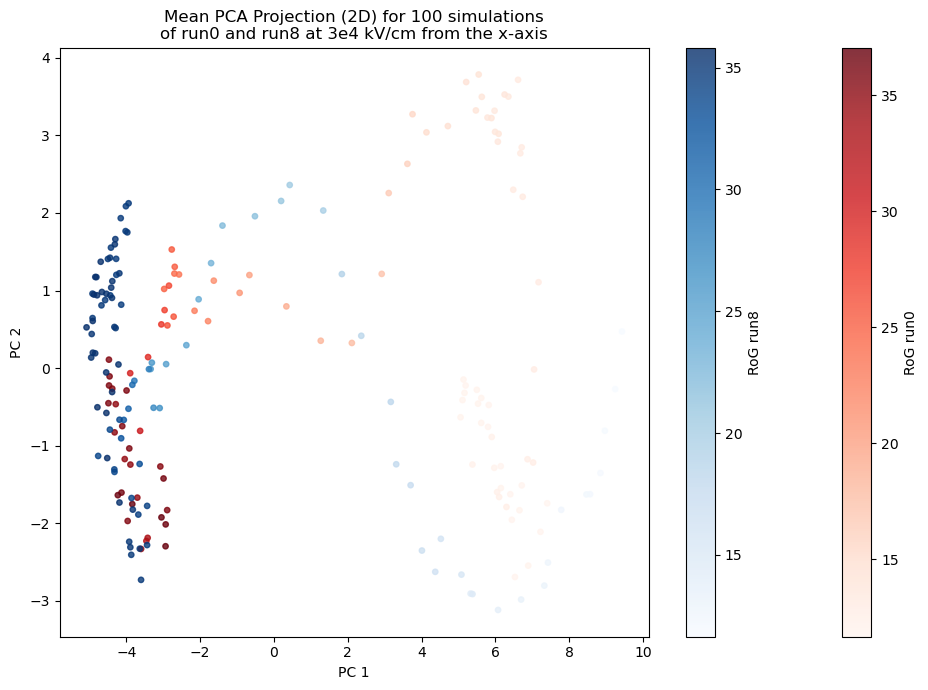

In [33]:
#PCA 2D mean

pca_data = PCA_analysis(all_img_stack, n_components=2)
#tsne_data = TSNE_analysis(all_img, n_components=2, perplexity=60.0, random_state=None)

#sum up every 100 rows to make a (10100,2) array into a (101,2) array
pca_data_sum = []
#tsne_data_sum = []
for i in range(len(fold_dirs)*2):
    pca_data_sum.append(np.mean(pca_data[i*100:(i+1)*100], axis=0))
    #tsne_data_sum.append(np.mean(tsne_data[i*100:(i+1)*100], axis=0))

# Convert lists to numpy arrays
pca_data_sum = np.array(pca_data_sum)
#tsne_data_sum = np.array(tsne_data_sum)
print(len(one_run_rog1))
print(len(one_run_rog2))
print(len(pca_data_sum))
# Scatterplot for PCA
plt.figure(figsize=(10, 7))
sc1 = plt.scatter(
    pca_data_sum[:101, 0], 
    pca_data_sum[:101, 1], 
    c=one_run_rog1,     
    cmap='Reds', 
    alpha=0.8,     
    s=15
)
sc2 = plt.scatter(
    pca_data_sum[101:, 0], 
    pca_data_sum[101:, 1], 
    c=one_run_rog2,     
    cmap='Blues', 
    alpha=0.8,     
    s=15
)
plt.colorbar(sc1, label=f'RoG {what_run1}') 
plt.colorbar(sc2, label=f'RoG {what_run2}')
plt.title(f"Mean PCA Projection (2D) for 100 simulations\nof {what_run1} and {what_run2} at {efield} kV/cm from the {axis_xyz}-axis")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()

# plt.figure(figsize=(10, 7))
# sc = plt.scatter(
#     tsne_data_sum[:, 0], 
#     tsne_data_sum[:, 1], 
#     c=one_run_rog,     
#     cmap='Reds', 
#     alpha=0.8,     
#     s=15
# )
# plt.colorbar(sc, label='Radius of Gyration') 
# plt.title(f"Mean TSNE Projection (2D) for 100 simulations\nof {what_run} at {efield} kV/cm from the {axis_xyz}-axis")
# plt.xlabel("TSNE 1")
# plt.ylabel("TSNE 2")
# plt.tight_layout()
# plt.show()


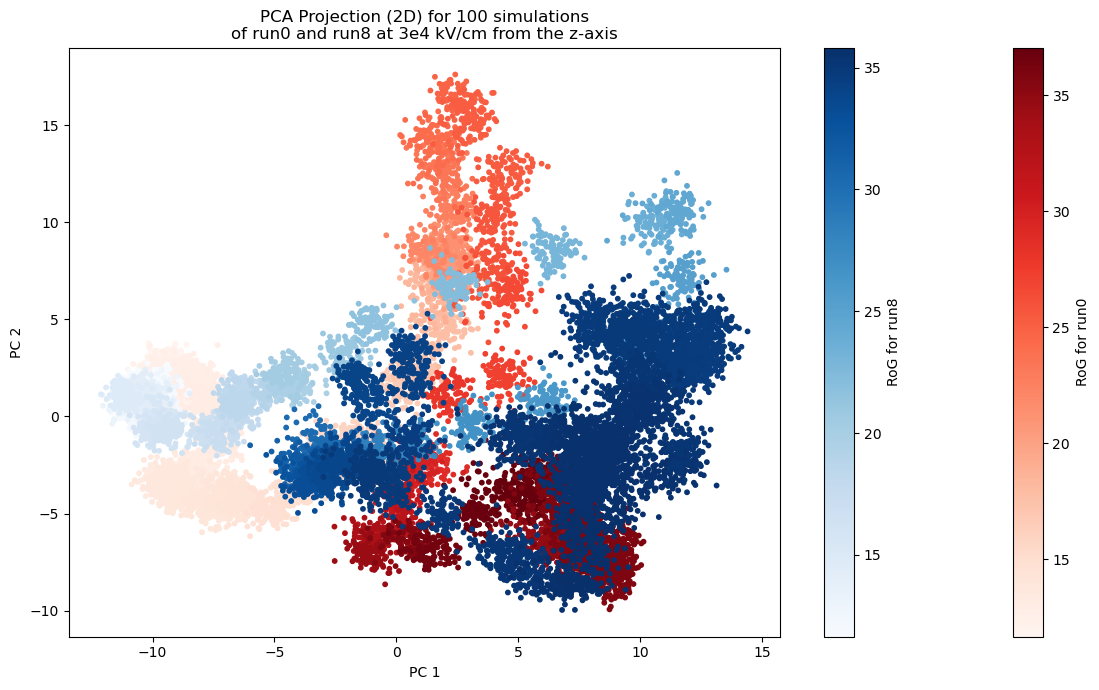

In [36]:
#PCA 2D
pca_data = PCA_analysis(all_img_stack, n_components=2)

plt.figure(figsize=(12, 7))
sc1 = plt.scatter(
    pca_data[:10100, 0], 
    pca_data[:10100, 1], 
    c=flattened_rog1,     
    cmap='Reds',      
    s=10
)
sc2 = plt.scatter(
    pca_data[10100:, 0], 
    pca_data[10100:, 1], 
    c=flattened_rog2,     
    cmap='Blues',      
    s=10
)
plt.colorbar(sc1, label=f'RoG for {what_run1}') 
plt.colorbar(sc2, label=f'RoG for {what_run2}') 
plt.title(f"PCA Projection (2D) for 100 simulations\nof {what_run1} and {what_run2} at {efield} kV/cm from the {axis_xyz}-axis")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.tight_layout()
plt.show()

plt.show()


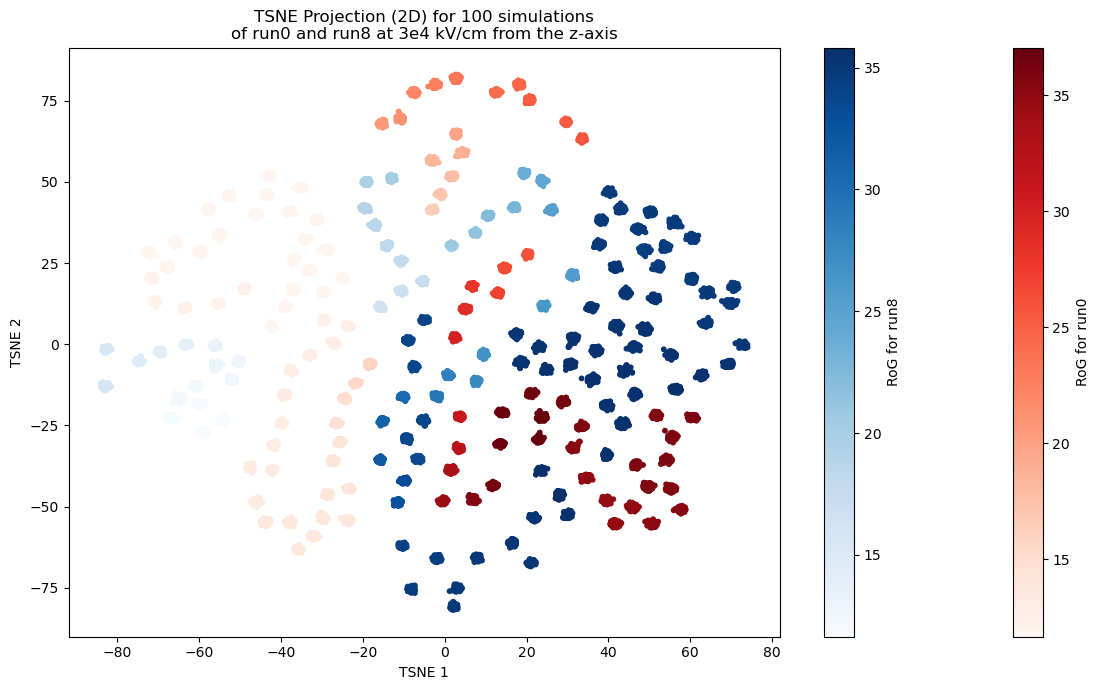

In [37]:
tsne_data = TSNE_analysis(all_img_stack, n_components=2, perplexity=80.0, random_state=None)

plt.figure(figsize=(12, 7))
sc1 = plt.scatter(
    tsne_data[:10100, 0], 
    tsne_data[:10100, 1], 
    c=flattened_rog1,     
    cmap='Reds',      
    s=10
)
sc2 = plt.scatter(
    tsne_data[10100:, 0], 
    tsne_data[10100:, 1], 
    c=flattened_rog2,     
    cmap='Blues',      
    s=10
)
plt.colorbar(sc1, label=f'RoG for {what_run1}') 
plt.colorbar(sc2, label=f'RoG for {what_run2}') 
plt.title(f"TSNE Projection (2D) for 100 simulations\nof {what_run1} and {what_run2} at {efield} kV/cm from the {axis_xyz}-axis")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.tight_layout()
plt.show()

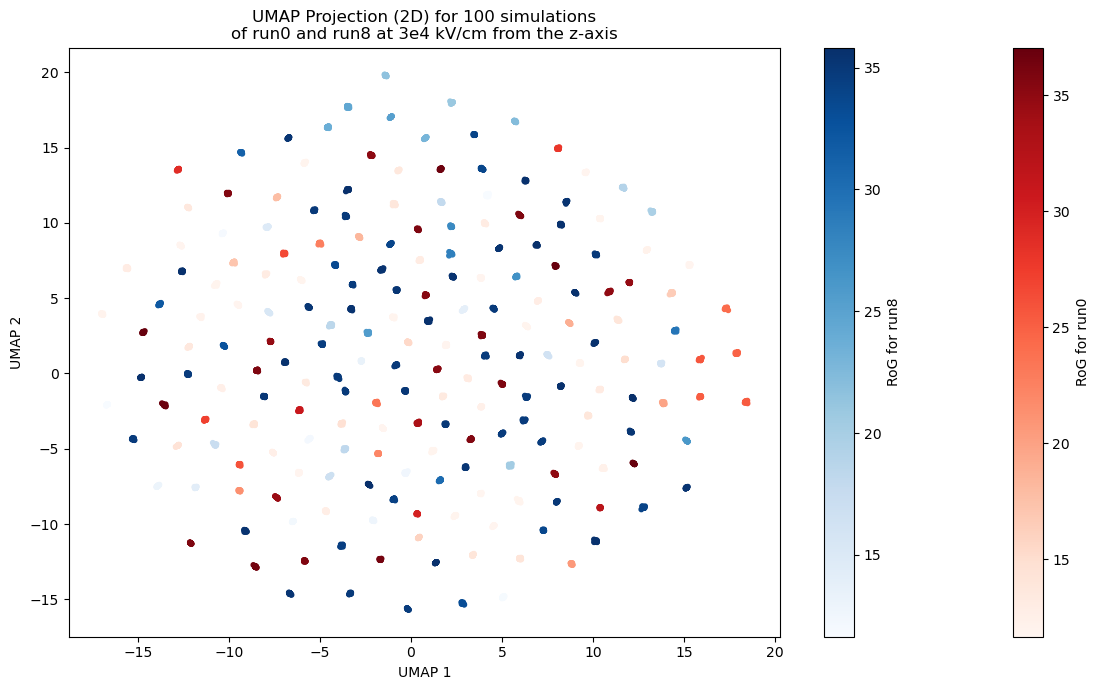

In [38]:
#UMAP 2D
umap_data = UMAP_analysis(all_img_stack, n_components=2)

plt.figure(figsize=(12, 7))
sc1 = plt.scatter(
    umap_data[:10100, 0], 
    umap_data[:10100, 1], 
    c=flattened_rog1,     
    cmap='Reds',      
    s=10
)
sc2 = plt.scatter(
    umap_data[10100:, 0], 
    umap_data[10100:, 1], 
    c=flattened_rog2,     
    cmap='Blues',      
    s=10
)
plt.colorbar(sc1, label=f'RoG for {what_run1}') 
plt.colorbar(sc2, label=f'RoG for {what_run2}') 
plt.title(f"UMAP Projection (2D) for 100 simulations\nof {what_run1} and {what_run2} at {efield} kV/cm from the {axis_xyz}-axis")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

3D plotting using Plotly

In [40]:
print(f"PCA_3D_{efield}_{what_run1}_and_{what_run2}_100sim_{axis_xyz}_d{detector_distance}_bin{num_bins}.html")
import plotly.graph_objects as go

pca_data = PCA_analysis(all_img_stack, n_components=3)

# Create interactive 3D scatter plot
trace1 = go.Scatter3d(
                    x=pca_data[:10100, 0], 
                    y=pca_data[:10100, 1],
                    z=pca_data[:10100, 2],
                    mode='markers',
                    marker=dict(
                        size=2,
                        color=flattened_rog1,
                        colorscale='Reds',
                        colorbar=dict(title=f'RoG {what_run1}', x=0.92),
                        opacity=1
                    ),
                    name=''
)

trace2 = go.Scatter3d(
                    x=pca_data[10100:, 0], 
                    y=pca_data[10100:, 1],
                    z=pca_data[10100:, 2],
                    mode='markers',
                    marker=dict(
                        size=2,
                        color=flattened_rog2,
                        colorscale='Blues',
                        colorbar=dict(title=f'RoG {what_run2}', x=1.0),
                        opacity=1
                    ),
                    name=''
)

# Combine trace1 and trace2
fig = go.Figure(data=[trace1, trace2])

fig.update_layout(
    scene=dict(
        xaxis_title='PC 1',
        yaxis_title='PC 2',
        zaxis_title='PC 3'
    ),
    title=f'PCA (3D) for 100 simulations\nof {what_run1} & {what_run2} at {efield} kV/cm from the {axis_xyz}-axis',
    showlegend=True
)

saveit = input(f'Save?: ')
if saveit == 'y':
    fig.write_html(f"/home/mans/results/PCA_3D_{efield}_{what_run1}_and_{what_run2}_100sim_{axis_xyz}_d{detector_distance}_bin{num_bins}.html")

fig.show()



PCA_3D_3e4_run0_and_run8_100sim_z_d50_bin30.html


In [29]:
#TSNE in 3D

tsne_data = TSNE_analysis(all_img, n_components=3, perplexity=50.0, random_state=None)
# Convert tsne data into a DataFrame
df = pd.DataFrame(tsne_data, columns=["TSNE 1", "TSNE 2", "TSNE 3"])
df["RoG"] = flattened_rog

# Create interactive 3D scatter plot
fig = px.scatter_3d(df, x="TSNE 1", y="TSNE 2", z="TSNE 3", 
                    color=df["RoG"], 
                    opacity=1, 
                    title=f'TSNE Projection 3D, from the {axis_xyz}-axis',
                    color_continuous_scale='Reds')

# Reduce marker size
fig.update_traces(marker=dict(size=2.5))

#fig.write_html(f"/home/mans/results/TSNE_3D_{efield}_{what_run}_100sim_{axis_xyz}_d{detector_distance}_bin{num_bins}.html")
print(f"TSNE_3D_{efield}_{what_run}_100sim_{axis_xyz}_d{detector_distance}_bin{num_bins}.html")
fig.show()

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10100 samples in 0.002s...
[t-SNE] Computed neighbors for 10100 samples in 0.712s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10100
[t-SNE] Computed conditional probabilities for sample 2000 / 10100
[t-SNE] Computed conditional probabilities for sample 3000 / 10100
[t-SNE] Computed conditional probabilities for sample 4000 / 10100
[t-SNE] Computed conditional probabilities for sample 5000 / 10100
[t-SNE] Computed conditional probabilities for sample 6000 / 10100
[t-SNE] Computed conditional probabilities for sample 7000 / 10100
[t-SNE] Computed conditional probabilities for sample 8000 / 10100
[t-SNE] Computed conditional probabilities for sample 9000 / 10100
[t-SNE] Computed conditional probabilities for sample 10000 / 10100
[t-SNE] Computed conditional probabilities for sample 10100 / 10100
[t-SNE] Mean sigma: 5.950203
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.019943
[t-SNE] KL

In [ ]:
#UMAP 3d

umap_data = UMAP_analysis(all_img, n_components=3)

# Convert PCA data into a DataFrame
df_umap = pd.DataFrame(umap_data, columns=["UMAP1", "UMAP2", "UMAP3"])
df_umap["RoG"] = flattened_rog  # Assign colors by radius of gyration on the x-axis

# Create interactive 3D scatter plot
fig = px.scatter_3d(df_umap, x="UMAP1", y="UMAP2", z="UMAP3", 
                    color="RoG", 
                    opacity=1, 
                    title=f"UMAP Projection (3D) from the {axis_xyz}-axis",
                    color_continuous_scale='Reds')

# Reduce marker size
fig.update_traces(marker=dict(size=1.5))

#fig.write_html(f"/home/mans/results/UMAP_3D_{efield}_{what_run}_100sim_{axis_xyz}_d{detector_distance}_bin{num_bins}.html")
print(f"UMAP_3D_{efield}_{what_run}_100sim_{axis_xyz}_d{detector_distance}_bin{num_bins}.html")
fig.show()


UMAP_3D_3e4_run0_100sim_z_d50_bin30.html
